# 3115 - Lab Programming Machine Learning

## Lab Exercise 8

## Yuvaraj Prem Kumar, 303384

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [2]:
# Importing sklearn libraries
import sklearn
from sklearn.model_selection import train_test_split

In [10]:
# Importing Pytorch libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter    
import torchvision
print("PyTorch Version %s" %torch.__version__)

PyTorch Version 1.3.1


In [4]:
%load_ext tensorboard

# Introduction

This lab exercise follows the same as SoSe2019 DDA Lab - which is implementing a research paper [1] titled "Time Series Classification Using Multi-Channels Deep Convolutional Neural Networks". I previously implemented it using TensorFlow, however this time it's implemented using PyTorch. This is a deep learning model on a time-series classification dataset, PAMAP2. The model proposed, MC-DCNN has each channel of which takes a single dimension of multivariate time series as input and learns features individually. The model combines the learnt features of each channel and feeds them into a Multilayer Perceptron (MLP) to perform classification.

A lot of explanations for the model architecture and data pre-processing are taken from my DDA Lab 6 submission (with minor changes)

## Part A: Data Pre-processing

From the dataset description [2]: "The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor. The dataset can be used for activity recognition and intensity estimation, while developing and applying algorithms of data processing, segmentation, feature extraction and classification."

A close study of the PAMAP2 readme file and in [3], the dataset creator defines which IMU measurement data is relevant. The research paper states; only 4 out of 19 activities are selected ‘standing’, ‘walking’, ‘ascending stairs, and ‘descending stairs’. As in [3], this means that the **most relevant** IMU position is the 3-D gyroscopic acceleration data. Each physical activity is a 3D time series, because of the 3D-acceleration data and corresponding activity. So we use the “3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit” measurement as the observations, with “activityID” as target. Hence, we will have 9 channels for the training / testing data.

The preprocessing steps are:
1. The train / test split is mentioned as leave-one-out cross validation (LOOCV). Here a more direct approach is chosen – one subject will be the test dataset, and the rest the training dataset. This is rotated.
2. The paper states that two subjects are dropped: Subject 108 and 109, because 108 is left-handed, and 109 does not perform the relevant activities.
3. Iteratively read each file. Fill NaNs with mean of other values, and drop the unwanted rows and columns.
4. Normalize the data, using $\frac{x-\mu}{\sigma}$. The data is centered to have mean of zero, and normalize its scale to [-1, 1] along each feature. The mean is computed only over the training data and then subtracted equally from all splits (train and test).
5. Sliding window is applied, based on sliding steps of {128,64,32,16,8} and window size of 256. However due to training time limitations (it's too long) I only use a sliding step of 128.

Functions *generate_data* and *sliding_window* are taken from my DDA Lab 6.

In [12]:
def generate_data(filelist, sliding_step):
    dir = './PAMAP2_Dataset/Protocol/'
    # Required columns
    columns = [1,  # Activity ID
               4, 5, 6, # IMU_hand, 3D-acceleration data
               21, 22, 23, # IMU_chest, 3D-acceleration data
               38, 39, 40  # IMU_ankle , 3D-acceleration data
              ]
    # Required rows
    ID_rows = [3, 4, 12, 13]  # standing, walking, ascending stairs, descending stairs
    data = []

    for file in filelist:
        input = dir + file
        print('Reading data file: ', input)
        df = pd.read_csv(input, header=None, delim_whitespace=True)
        df = df.fillna(df.mean())  # Replace NaNs with mean of column
        df = df[df[1].isin(ID_rows)]  # Keep only the required rows & drop the rest
        df = df[columns]  # Keep only the required columns & drop the rest
        data.append(df)
    df = pd.concat(data)  # Merge into one dataframe

    # Normalize X_dataframe as per http://cs231n.github.io/neural-networks-2/
    x_df = df.drop(1, axis=1)  # Drop target column (Activity ID)
    x_df -= np.mean(x_df, axis=0)
    x_df /= np.std(x_df, axis=0)

    y_df = pd.get_dummies(df[1])  # One-hot encoding for this categorical target data (Activity ID)

    # Sliding window based on research paper
    X_data,Y_data=sliding_window(x_df,y_df,sliding_step)
    return X_data, Y_data

In [13]:
def sliding_window(x_df,y_df,step):
    window_size = 256  # Constant
    ylen = len(y_df)  # Length of target
    max_step = ylen // step  # Sliding over dataframe
    X_data = []
    Y_data = []
    # https://www.geeksforgeeks.org/window-sliding-technique/
    for i in range(0, max_step):
        start = i * step
        end = window_size + (i * step)
        if end > ylen:
            start = ylen - window_size
            end = ylen
        X_data.append(np.array(x_df[start:end]))
        arr = y_df[start:end]
        Y_data.append(np.array(arr.sum() / len(arr)))
    # Convert to ndarray for Pytorch
    X_data = np.array(X_data)
    Y_data = np.argmax(np.array(Y_data), axis=1)

    return X_data, Y_data

Here we can define which subjects should be traininig data or testing data.

In [14]:
train_filelist = ['subject102.dat', 'subject103.dat', 'subject104.dat', 'subject105.dat','subject106.dat','subject107.dat']
test_filelist = ['subject101.dat']

In [15]:
X_data, y_data = generate_data(train_filelist, sliding_step=128)
print('Shape of X_Train: ', X_data.shape)
print('Shape of Y_Train: ', y_data.shape)

Reading data file:  ./PAMAP2_Dataset/Protocol/subject102.dat
Reading data file:  ./PAMAP2_Dataset/Protocol/subject103.dat
Reading data file:  ./PAMAP2_Dataset/Protocol/subject104.dat
Reading data file:  ./PAMAP2_Dataset/Protocol/subject105.dat
Reading data file:  ./PAMAP2_Dataset/Protocol/subject106.dat
Reading data file:  ./PAMAP2_Dataset/Protocol/subject107.dat
Shape of X_Train:  (3891, 256, 9)
Shape of Y_Train:  (3891,)


In [16]:
X_valid, y_valid = generate_data(test_filelist, sliding_step=128)
print('Shape of X_Test: ', X_valid.shape)
print('Shape of Y_Test: ', y_valid.shape)

Reading data file:  ./PAMAP2_Dataset/Protocol/subject101.dat
Shape of X_Test:  (584, 256, 9)
Shape of Y_Test:  (584,)


In order to make use of the Pytorch DataLoader functionality, it should be in a tensor format firstly. Normally we would inherit the class "Dataset", however since the dataset is in numpy arrays (3D and 2D), we can directly use the DataLoader. Note the use of *permute* - in Tensorflow the expected format for convolutional layers is [batch, width, channels] but in Pytorch the format is [batch, channels, width]. Since I reused my old sliding window code, *permute* is used to swap the axes.

In [17]:
X_train=torch.from_numpy(X_data)
y_train=torch.from_numpy(y_data)
X_test=torch.from_numpy(X_valid)
y_test=torch.from_numpy(y_valid)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([3891, 256, 9]),
 torch.Size([3891]),
 torch.Size([584, 256, 9]),
 torch.Size([584]))

In [18]:
batch_size = 100
training_dataset = torch.utils.data.TensorDataset(X_train.permute(0,2,1), y_train)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False)

testing_dataset = torch.utils.data.TensorDataset(X_test.permute(0,2,1), y_test)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [19]:
writer = SummaryWriter()

Now our custom dataset is put to the DataLoader for training and testing dataset. And we can call it iteratively during the training and testing phase.

## Part B: MC-DCNN Model Architecture

This is the proposed model from the research paper:

<img src="https://i.imgur.com/X2A0lPE.jpg" width="65%"/>

We use three main types of layers to build CNN architectures [4]: 
* Convolutional Layer: which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map
* Pooling Layer: down-sample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time
* Fully-Connected Layer: perform classification on the features extracted by the convolutional layers and down-sampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

Instead of images as per regular use of CNNs, here the classification is of multiple 1D time-series classifications. Hence, there are N-channels input with length (window size) of 256. Each channel is fed into a 2-stages feature extractor which learns features through filter layer, activation layer, and pooling layer. For example, input channel is passed to the first 1D convolution layer (filter and activation), then goes into the first 1D pooling layer, then into the second 1D convolution layer, into the second 1D pooling layer. After the features are learned, it is passed to the fully-connected layer, after that is flattened and the softmax is computed, giving the final output (classifications). The diagram below [5] shows the overall flow, along with the dimensions.

<img src="https://i.imgur.com/bBr4hS1.jpg" width="45%"/>

The CNN class code-block and subsequent training/testing code-block are adapted from the official Pytorch documentation [6] and from [7,8,9]. CNN examples online are mostly for image classification, but the same methodlogy can be applied for this time-series classification, by paying close attention to the dimensions.

In [20]:
class MC_DCNN(nn.Module):
    def __init__(self):
        super(MC_DCNN, self).__init__()
        
        # Convolutional layer 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(9, 8, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size = 2, stride = 2))
        
        # Convolutional layer 2
        self.conv2 = nn.Sequential(
            nn.Conv1d(8, 4, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size = 2, stride = 2))
        
        # Fully-connected layer 1
        self.fc1 = nn.Linear(244, 732)
        
        # Fully-connected layer 2
        self.fc2 = nn.Linear(732, 4)

    # Feedforward phase
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten output before feeding to fully-connected layers
        x = self.fc1(x)
        x = F.relu(x)
        out = self.fc2(x)
        return out

In [29]:
net = MC_DCNN()
print('Model architecture:', net)

Model architecture: MC_DCNN(
  (conv1): Sequential(
    (0): Conv1d(9, 8, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (conv2): Sequential(
    (0): Conv1d(8, 4, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (fc1): Linear(in_features=244, out_features=732, bias=True)
  (fc2): Linear(in_features=732, out_features=4, bias=True)
)


There are various things that need to be handled in Pytorch, often discoverable after numerous debugging and errors:
* The input (X) to the model should be float
* The output (y_hat etc) should be of long type
* Torch.nn.CrossEntropyLoss already combines softmax + logloss. And this function only expects 1D inputs.

In [30]:
#The following parameters are used in the training:
epochs = 20
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [31]:
train_loss_hist, test_accuracy = [], []
total_step = len(train_loader)

tb = SummaryWriter()



for epoch in range(epochs):

    train_loss = 0.0
    test_loss = 0.0
    correct = 0
    total = 0
    
    # SGD implementation
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.float())
        
        # Calculate cross entropy loss
        loss = criterion(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Plotting training loss
    epoch_train_loss = train_loss / len(data)
    train_loss_hist.append(epoch_train_loss)
    
    tb.add_scalar('Loss on train set', loss.item(), epoch)
        
    # Predictions on test set
    for data in test_loader:
        images, labels = data
        outputs = net(images.float())
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    # Plotting test accuracy
    
    #test_accuracy.append((correct/total)/ len(data))
    test_accuracy.append((correct/total))
    
    # Tensorboard
    tb.add_histogram("Activations", correct)
    tb.add_scalar('Accuracy on test set', correct / total, epoch)
        
    if (i + 1) % 1 == 0:
        print('Epoch [{}/{}]: Training loss: {:.4f}, Test accuracy: {:.2f} %'
                  .format(epoch + 1, epochs, loss.item(), (correct / total) * 100))
tb.close()

Epoch [1/20]: Training loss: 0.1387, Test accuracy: 56.16 %
Epoch [2/20]: Training loss: 0.8444, Test accuracy: 52.40 %
Epoch [3/20]: Training loss: 0.6382, Test accuracy: 57.02 %
Epoch [4/20]: Training loss: 0.3988, Test accuracy: 62.33 %
Epoch [5/20]: Training loss: 0.4872, Test accuracy: 67.12 %
Epoch [6/20]: Training loss: 0.5712, Test accuracy: 77.57 %
Epoch [7/20]: Training loss: 0.5150, Test accuracy: 86.82 %
Epoch [8/20]: Training loss: 0.6841, Test accuracy: 89.21 %
Epoch [9/20]: Training loss: 0.6820, Test accuracy: 89.38 %
Epoch [10/20]: Training loss: 0.7168, Test accuracy: 89.55 %
Epoch [11/20]: Training loss: 0.7141, Test accuracy: 88.01 %
Epoch [12/20]: Training loss: 0.7448, Test accuracy: 88.18 %
Epoch [13/20]: Training loss: 0.7400, Test accuracy: 88.70 %
Epoch [14/20]: Training loss: 0.7261, Test accuracy: 89.38 %
Epoch [15/20]: Training loss: 0.6696, Test accuracy: 89.38 %
Epoch [16/20]: Training loss: 0.6271, Test accuracy: 89.21 %
Epoch [17/20]: Training loss: 0.6

In [32]:
def plotting(training_loss, testing_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('MC-DCNN', fontsize=20)
    ax[0].plot(training_loss, label='Train', color='red')
    ax[0].set_title("Cross Entropy Loss on Train Set")
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(testing_accuracy, color='green')
    ax[1].set_title("Accuracy on Test Set")
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    plt.show()

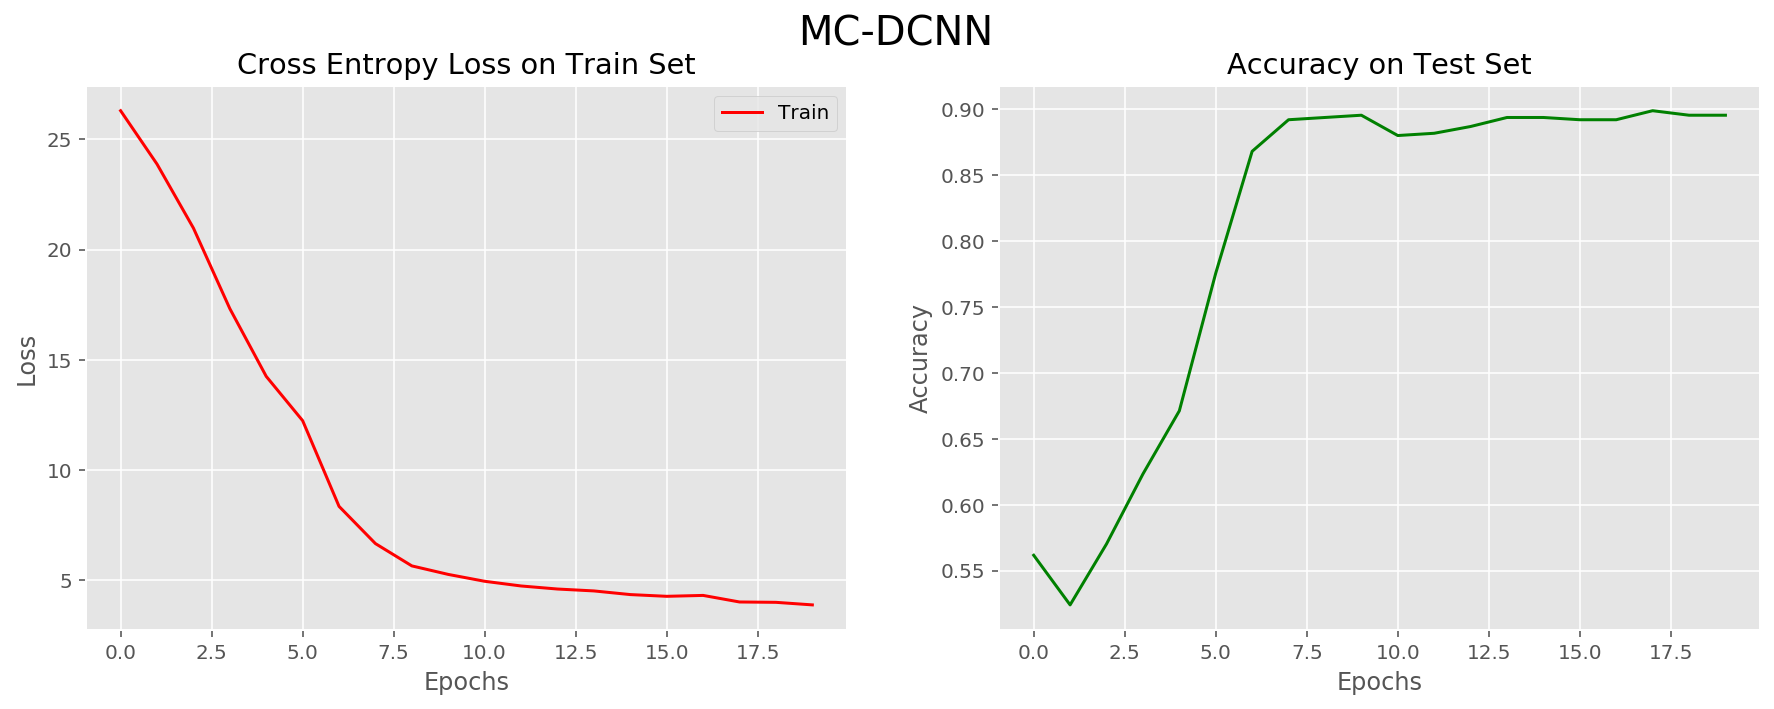

In [33]:
plotting(train_loss_hist, test_accuracy) 

* As expected, the training loss decreases as it converges to the local minima. 
* The test accuracy increases accordinly, as model feedforwards using the learnt weights and biases to make predictions.
* The accuracy score is similar to sklearns' accuracy metric

Now we can run the Tensorboard to visualize the data. Actually we can use Tensorboard pretty much to visualize it real time. The code is inside the main for loop, adapted from [10].

<img src="https://i.imgur.com/QGlOhmr.jpg" align="left" width="45%"/><img src="https://i.imgur.com/ZwOYtjB.jpg" align="left" width="45%"/><br>
<img src="https://i.imgur.com/9qds2s2.jpg" width="45%"/>

## Summary
1. Obviously my implementation was not 100% the same as the research paper - as many parameters and algorithms were not clearly stated. Hence my own interpretation of the model. Also, the training phase differs from the LOOCV and sliding window size as explained. I believe that just one instance is enough for the recreation purpose, as we would like to simply see an implementation of a research paper in PyTorch and this fulfils that purpose.
2. The code seems to be simple with few lines, but alot of work particularly the calculations of the convolving layers need to be handled before the streamlined code can be produced.
3. One of the major changes was the use of ReLU activation functions after the convolutional and fully-connected layers instead of sigmoid as in the paper. I found better accuracies and loss minimization using ReLU activations.
4. This was a good exercise to see the pros and cons of Pytorch versus TensorFlow. Many things are easier to implement in Pytorch. However, it is much easier to find examples and forum support for TensorFlow since that library is more mature and has a larger userbase (for now). Hence if needed to implement a CNN right now, I would go for TensorFlow (with Keras). having said that I would except PyTorch to surpass TensorFlow usage eventually.


# References

[1] Zheng, Y., Liu, Q., Chen, E., Ge, Y., & Zhao, J. L. (2014, June). Time series classification using multi-channels deep convolutional neural networks. In International Conference on Web-Age Information Management (pp. 298-310). Springer, Cham.<br>
[2] https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring <br>
[3] https://kluedo.ub.uni-kl.de/frontdoor/deliver/index/docId/3681/file/PhDThesis_AttilaReiss.pdf <br>
[4] https://cs231n.github.io/neural-networks-1/ <br>
[5] http://aqibsaeed.github.io/2016-11-04-human-activity-recognition-cnn/ <br>
[6] https://pytorch.org/docs/stable/nn.html <br>
[7] https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/ <br>
[8] https://www.guru99.com/pytorch-tutorial.html <br>
[9] https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/ <br>
[10] https://pytorch.org/docs/stable/tensorboard.html <br>